In [1]:
# 5. 상품 정보와 거래 정보를 바탕으로 해당 거래가 반품될 가능성을 예측하는 로지스틱 회귀 모델을 만드세요.
# 필요한 데이터를 정리하고 결측치와 이상치를 제거해주세요.
# Quantity 피쳐를 활용해 IsReturn 피쳐를 생성하세요.
# 모델 학습에 사용할 적절한 피쳐를 선정하세요.
# 모델 학습과 검증을 위해 데이터셋을 train셋과 test셋으로 나누세요.
# IsReturn을 예측하는 로지스틱 회귀 모델을 학습하세요.
# 혼동행렬, 정밀도, 재현율, F1-score 등 다양한 평가지표를 사용하여 모델의 성능을 평가하세요.
# 모델의 성능을 더 높일 수 있는 방안에 대해서 고민해보세요.

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score

df = pd.read_csv(r"C:\Users\dongu\Downloads\archive\Online_Retail.csv", encoding ='latin1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
# 필요 피쳐만 선택
df = df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
#결측치제거

df = df.dropna()

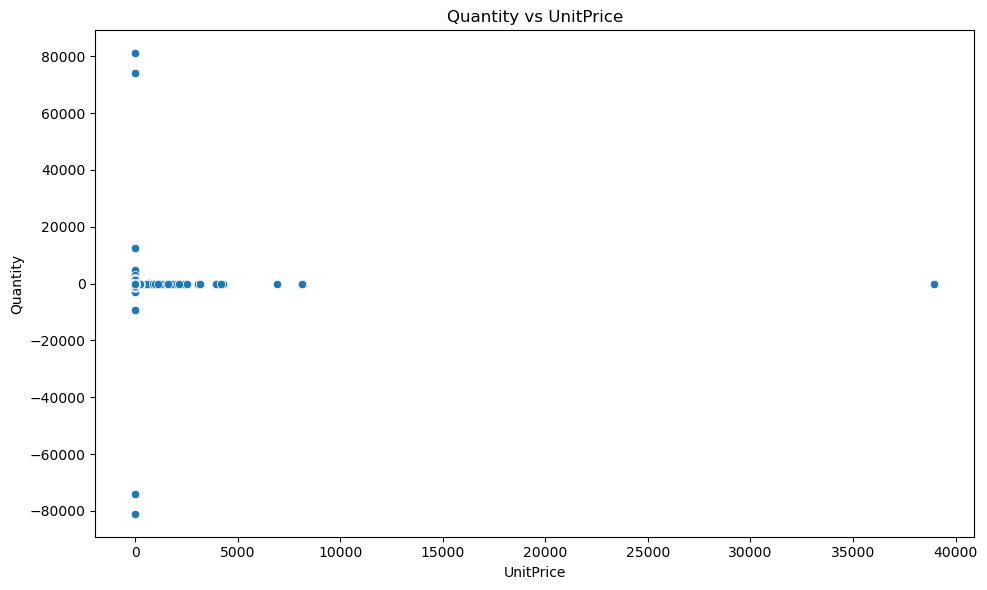

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UnitPrice', y='Quantity', data=df)
plt.title('Quantity vs UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Quantity')
plt.tight_layout()
plt.show()

In [8]:
#이상값 제거
df = df[(df['Quantity'] > -1000) & (df['Quantity'] < 1000)]
df = df[(df['UnitPrice'] > 0) & (df['UnitPrice'] < 10000)]


In [9]:
# Quantity 피쳐를 활용해 IsReturn 피쳐를 생성
df['Quantity'].value_counts()


Quantity
1      73301
12     60031
2      57999
6      37688
4      32180
       ...  
59         1
490        1
388        1
232        1
698        1
Name: count, Length: 376, dtype: int64

In [10]:
QC = df.groupby('Quantity')['InvoiceNo'].sum() # QC는 수량대비 취소

In [11]:
QC


Quantity
-960                                              C552568
-840                                              C570556
-828                                              C563577
-756                                              C567527
-720                         C545478C570556C570556C572343
                              ...                        
 912                                               573153
 960    5395785506675506675506675506675546425612425654...
 968                                               563074
 972                                         537657537657
 992                                               574293
Name: InvoiceNo, Length: 376, dtype: object

In [12]:
# 'IsReturn' 피쳐 생성 (반품: 1, 판매: 0)
df['IsReturn'] = df['Quantity'].apply(lambda x: 1 if x < 0 else 0)

In [13]:
df['IsReturn'].value_counts()

IsReturn
0    397769
1      8892
Name: count, dtype: int64

In [15]:
# 반품 거래의 경우, Quantity를 양수로 변환하여 사용
df['Quantity'] = df['Quantity'].abs()

In [16]:
df['IsReturn'].value_counts()

IsReturn
0    397769
1      8892
Name: count, dtype: int64

In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month

C:\Users\dongu\AppData\Local\Temp\ipykernel_4428\806820592.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [18]:
top_countries = df['Country'].value_counts().nlargest(10).index
df['Country'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

In [19]:
# 모델 학습에 사용할 피쳐 선정 및 데이터 분리
# 독립변수(X): 'UnitPrice', 'Country', 'Month'
# 종속변수(y): 'IsReturn'
X = df[['UnitPrice', 'Country', 'Month']]
y = df['IsReturn']

In [20]:
# 원핫 인코딩
X = pd.get_dummies(X, columns=['Country', 'Month'], drop_first=True)

In [21]:
# 훈련셋과 테스트셋으로 분리 (80% 훈련, 20% 테스트)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# 로지스틱 회귀 모델 학습
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

In [23]:
# 모델 성능 평가
y_pred = model.predict(X_test)

In [25]:
cm = confusion_matrix(y_test, y_pred)
print("혼동 행렬 (Confusion Matrix)")
print(cm)
print("\n평가지표 (Classification Report)")
print(classification_report(y_test, y_pred))

혼동 행렬 (Confusion Matrix)
[[79551     4]
 [ 1773     5]]

평가지표 (Classification Report)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     79555
           1       0.56      0.00      0.01      1778

    accuracy                           0.98     81333
   macro avg       0.77      0.50      0.50     81333
weighted avg       0.97      0.98      0.97     81333



In [26]:
# 혼동행렬에서 
# 79551은 True Negative (TN)로 반품이 아닌 거래를 정확히 예측
# 4는 False Positive (FP)로 1건의 반품이 아닌 거래를 반품으로 잘못 예측
# 1773는 False Negative (FN)로 실제 반품을 반품이 아니라고 잘못 예측
# 5는 True Positive (TP) 5건의 실제 반품을 반품으로 정확히 예측

In [27]:
#평가지표

# 정확도(Accuracy): 약 ${98%}$로 매우 높습니다. 
# 하지만 이는 반품이 아닌 거래(0)의 비율이 매우 높아 나타난 수치로, 모델의 성능을 제대로 반영하지 못합니다.

# 정밀도(Precision), 재현율(Recall), F1-점수(F1-score): 반품(1) 클래스의 경우 모든 지표가 0으로 나타났습니다. 
# 이는 모델이 단 한 건의 반품도 제대로 예측하지 못했음을 의미합니다.


In [ ]:
# #모델 성능을 높이이 위해서



# 클래스 불균형 해결:

# 오버샘플링(Oversampling): 소수 클래스(반품)의 데이터를 복제하거나 새로운 데이터를 생성(예: SMOTE 기법)하여 
# 훈련 데이터의 균형을 맞춥니다.

# 언더샘플링(Undersampling): 다수 클래스(정상 판매)의 데이터를 무작위로 줄여 훈련 데이터의 균형을 맞춥니다.

# 피처 엔지니어링:

# TotalPrice(Quantity * UnitPrice)와 같은 새로운 변수를 생성하여 모델에 추가합니다.

# CustomerID나 StockCode를 기반으로 고객의 총 구매액, 반품 이력, 상품의 반품률 등과 같은 통계적 피처를 생성하여 활용할 수
# 있습니다.

# 다른 모델 사용:

# 로지스틱 회귀 모델 대신 결정 트리(Decision Tree), 랜덤 포레스트(Random Forest), 
# 또는 XGBoost와 같이 불균형 데이터에 더 잘 작동하는 모델을 사용해 볼 수 있습니다. 
# 이러한 모델들은 소수 클래스의 특성을 더 잘 포착할 수 있습니다.